# Sentiment Analysis Using Movie Reviews

### 1. Get the stemmed data using the same process you did in Week 3.

In [8]:
# import the data
import pandas as pd
movie_df = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

In [9]:
# convert all to lowercase
movie_df['review'] = movie_df['review'].str.lower()

In [10]:
# remove punctuation
import unicodedata
import sys

punctuation = dict.fromkeys(
    (i for i in range(sys.maxunicode)
    if unicodedata.category(chr(i)).startswith('P')
    ),
    None
)

movie_df['review'] = [string.translate(punctuation) for string in movie_df['review']]

In [11]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

movie_df['review'] = movie_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Load the stemmer library
from nltk.stem.porter import PorterStemmer

In [13]:
# Stem the review

# create a stemmer object
porter_stemmer = PorterStemmer()

# Split sentences
movie_df['review'] = movie_df['review'].apply(lambda x : filter(None,x.split(" ")))

# apply stemmer
movie_df['review'] = movie_df['review'].apply(lambda x : [porter_stemmer.stem(y) for y in x])

# rejoin sentences
movie_df['review'] = movie_df['review'].apply(lambda x : " ".join(x))

In [14]:
# show the first few rows of the data
movie_df.head()

,id,sentiment,review
0,"""5814_8""",1,stuff go moment mj ive start listen music watc...
1,"""2381_9""",1,classic war world timothi hine entertain film ...
2,"""7759_3""",0,film start manag nichola bell give welcom inve...
3,"""3630_4""",0,must assum prais film greatest film opera ever...
4,"""9495_8""",1,superbl trashi wondrous unpretenti 80 exploit ...


### 2. Split this into a training and test set.

In [15]:
# import the library
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(movie_df, test_size = 0.2, random_state = 1)

In [16]:
# show the first few rows of the test data
test_df.head()

,id,sentiment,review
21492,"""2161_10""",1,mani us wish could throw away social cultur ob...
9488,"""4950_8""",1,know end movi import cast direct act nice see ...
16933,"""4942_7""",1,admit first half hour movi basic lost mildli a...
12604,"""668_7""",1,watch last wave school fine art librari intrig...
8222,"""8689_7""",1,perfect cast fewperson drama simon dead someho...


In [17]:
# show the first few rows of the training data
train_df.head()

,id,sentiment,review
6655,"""8746_2""",0,obviou attack microsoft made peopl dont appear...
6085,"""1741_9""",1,dramat film whole sens word tell tail greec li...
21848,"""2430_10""",1,casper friendli ghost short childhood rewatch ...
5106,"""8797_8""",1,great idea 11 stori 11 septemb 11 director dif...
21856,"""799_2""",0,way concept behind storylin rather interest bl...


In [20]:
# show the dimensions of each data set to ensure an accurate 20% split
print("Test data dimensions:", test_df.shape)
print("Training data dimensions:", train_df.shape)

Test data dimensions: (5000, 3)
Training data dimensions: (20000, 3)


### 3. Fit and apply the tf-idf vectorization to the training set.

In [21]:
# import the library
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# Create the tf-idf object
tfidf = TfidfVectorizer()

# fit the vectorization to the training set
train_matrix = tfidf.fit_transform(train_df['review'])

### 4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

We do not want to use the testing data set to train the model since that could possibly lead to over-stated accuracy when the model is tested.

In [25]:
# apply the tf-idf vectorization to the test set
test_matrix = tfidf.transform(test_df['review'])

### 5. Train a logistic regression using the training data.

In [26]:
# import the library
from sklearn.linear_model import LogisticRegression

In [27]:
# create the logistic regression object
logit = LogisticRegression()

In [29]:
# train the regression using the training data
logit.fit(train_matrix, train_df['sentiment'])

LogisticRegression()

### 6. Find the model accuracy on test set.

In [30]:
# predict sentiment values on the test data using the model
test_pred = logit.predict(test_matrix)

In [32]:
# show the first few predictions
pd.DataFrame(test_pred, columns=['predicted sentiment']).head()

,predicted sentiment
0,1
1,1
2,0
3,1
4,1


In [33]:
# join the original test data with the predictions
test_df['predicted sentiment'] = test_pred

In [36]:
# calculate accuracy
import numpy as np
test_df['check'] = np.where((test_df['sentiment']==test_df['predicted sentiment']),1,0)
print("Model accuracy:", len(test_df[test_df['check']==1])/len(test_df))

Model accuracy: 0.8864


### 7. Create a confusion matrix for the test set predictions.

In [41]:
# import the libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [39]:
# create the confusion matrix
c_matrix = confusion_matrix(test_df['sentiment'], test_df['predicted sentiment'])

In [40]:
# create a dataframe from the confusion matrix
confusion_df = pd.DataFrame(c_matrix)

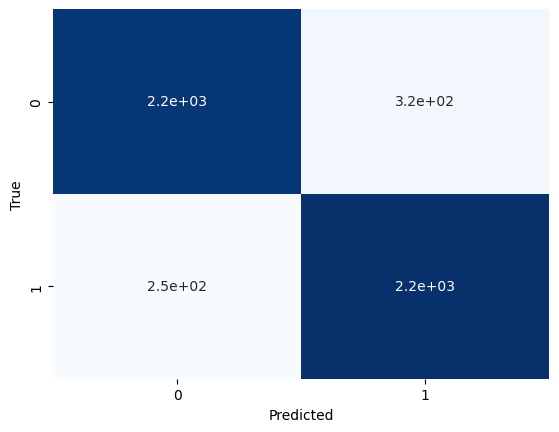

In [42]:
# create a heatmap
sns.heatmap(confusion_df, annot = True, cbar = None, cmap = "Blues")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### 8. Get the precision, recall, and F1-score for the test set predictions.

In [44]:
# import the library
from sklearn.model_selection import cross_val_score

In [47]:
# get the precision
cross_val_score(logit, test_matrix, test_df['sentiment'], scoring="precision")

array([0.84310019, 0.83883495, 0.84571429, 0.82189239, 0.89049587])

In [48]:
# get the recall
cross_val_score(logit, test_matrix, test_df['sentiment'], scoring="recall")

array([0.892     , 0.864     , 0.88977956, 0.88777555, 0.86372745])

In [49]:
# get the F1-score
cross_val_score(logit, test_matrix, test_df['sentiment'], scoring="f1")

array([0.86686103, 0.85123153, 0.8671875 , 0.85356455, 0.87690743])

### 9. Create a ROC curve for the test set.

In [50]:
# import the library
from sklearn.metrics import roc_curve, roc_auc_score

In [51]:
# calculate predicted probabilities
target_probabilities = logit.predict_proba(test_matrix)[:,1]

In [52]:
# calculate false positives and true positives
false_positive_rate, true_positive_rate, threshold = roc_curve(test_df['sentiment'], target_probabilities)

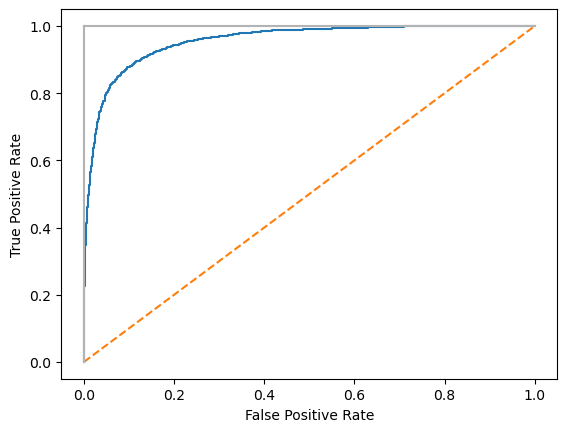

In [53]:
# plot ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0,1], ls="--")
plt.plot([0,0], [1,0], c=".7")
plt.plot([1,1], c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()